# **Local Outlier Factor (LOF)**

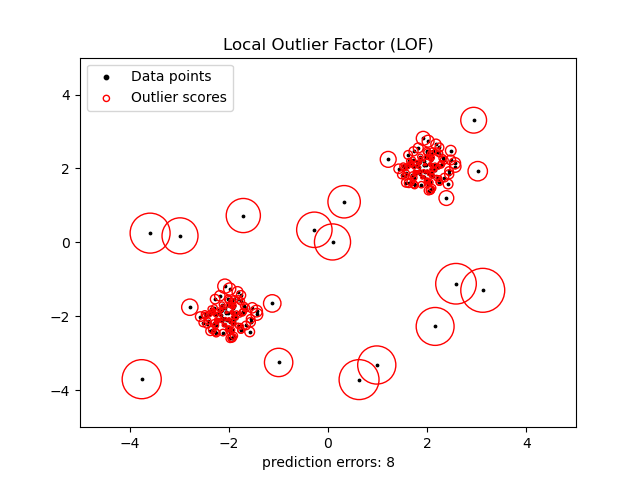

En este notebook , se tiene como objetivo mostrar el uso del modelo Local Outlier Factor (LOF) para la detección de anomalías en un conjunto de datos y mostrar su API de uso. El modelo LOF es un algoritmo de detección de anomalías basado en la densidad local de los puntos de datos. Se utiliza para identificar puntos que tienen una densidad significativamente menor que sus vecinos, lo que sugiere que son anomalías o outliers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import seaborn as sns
import sys, os
proj_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)

## Dataset
información sobre el dataset 

In [2]:
url_data='https://drive.google.com/uc?export=download&id=1jGJ-Bam7dR9vH4Y6-677LNNpW-PulLfL'
data=pd.read_csv(url_data,header=0)
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [4]:
data['fraud']=data['fraud'].astype(np.int8)
data['fraud'].value_counts()

fraud
0    912597
1     87403
Name: count, dtype: int64

In [ ]:
from PyOD_ADGE.models.lof import LOF
model = LOF('clasic')
model

In [6]:
X= data.drop(columns=['fraud']).values
model.fit(X)

KeyboardInterrupt: 

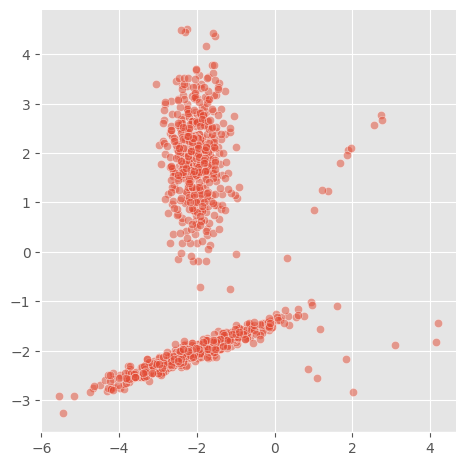

In [23]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=2,
                           n_informative=2, n_redundant=0,
                           weights=[0.98], flip_y=0,
                           class_sep=2, random_state=42)

plt.style.use('ggplot')
sns.relplot(x=X[:,0],y=X[:,1],alpha=0.5)
plt.show()

In [14]:
from PyOD_ADGE.models.local_outlier_factor import LocalOutlierFactor
model= LocalOutlierFactor()
model.fit(X)

LocalOutlierFactor()

In [15]:
scores = model.outlier_factor_
scores

array([0.97816495, 1.07962648, 1.00245579, 1.25511031, 1.59527451,
       1.08511804, 1.28936399, 0.99257805, 1.08225754, 1.01529392,
       1.06763841, 0.99420322, 1.06234402, 1.01044819, 0.96906626,
       1.06536118, 1.39283759, 0.98686028, 1.04658681, 1.22205286,
       0.97048118, 1.02282512, 0.9980611 , 1.12350822, 1.05560971,
       0.98420407, 1.70957666, 1.19820996, 1.08572911, 4.62652995,
       1.23551367, 0.99706133, 0.98207361, 1.16133627, 0.98420276,
       0.98503831, 1.02692061, 1.5133085 , 0.99516094, 0.99528309,
       1.4662874 , 1.00805337, 1.08610083, 0.97040376, 1.02580165,
       1.00483727, 1.0486088 , 1.0056529 , 1.11476856, 1.01280126,
       0.97467837, 1.13949876, 1.0265915 , 1.19896026, 1.06388637,
       1.05242899, 1.07555934, 1.04136601, 1.00155139, 0.97608171,
       0.97221229, 0.98710135, 0.99608691, 1.05388152, 1.05973255,
       1.00511039, 1.13793035, 1.10983431, 1.13731132, 0.97823421,
       0.9785091 , 1.16130772, 1.01649933, 1.06447824, 1.02421

In [16]:
from sklearn.neighbors import LocalOutlierFactor as LOF
model2= LOF(n_neighbors=20, algorithm='auto', metric='euclidean')
model2.fit(X)

LocalOutlierFactor(metric='euclidean')

In [17]:
scores2=model2.negative_outlier_factor_
scores2

array([-0.97816495, -1.07962648, -1.00245579, -1.25511031, -1.59527451,
       -1.08511804, -1.28936399, -0.99257805, -1.08225754, -1.01529392,
       -1.06763841, -0.99420322, -1.06234402, -1.01044819, -0.96906626,
       -1.06536118, -1.39283759, -0.98686028, -1.04658681, -1.22205286,
       -0.97048118, -1.02282512, -0.9980611 , -1.12350822, -1.05560971,
       -0.98420407, -1.70957666, -1.19820996, -1.08572911, -4.62652995,
       -1.23551367, -0.99706133, -0.98207361, -1.16133627, -0.98420276,
       -0.98503831, -1.02692061, -1.5133085 , -0.99516094, -0.99528309,
       -1.4662874 , -1.00805337, -1.08610083, -0.97040376, -1.02580165,
       -1.00483727, -1.0486088 , -1.0056529 , -1.11476856, -1.01280126,
       -0.97467837, -1.13949876, -1.0265915 , -1.19896026, -1.06388637,
       -1.05242899, -1.07555934, -1.04136601, -1.00155139, -0.97608171,
       -0.97221229, -0.98710135, -0.99608691, -1.05388152, -1.05973255,
       -1.00511039, -1.13793035, -1.10983431, -1.13731132, -0.97

- -1: indica que el punto es un outlier.
- 1: indica que el punto es un inlier.

In [18]:
ypred=model.decision_function()
ypred

array([ 1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1, -1,  1,
       -1,  1,  1, -1,  1

In [19]:
ypred2=model2.fit_predict(X)
ypred2

array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1

In [20]:
(ypred==ypred2).sum()

947

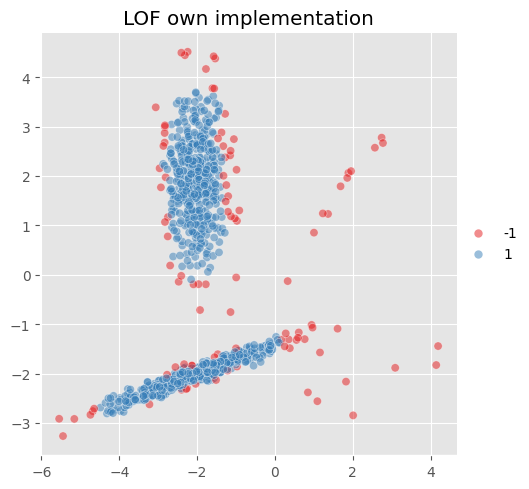

In [21]:
sns.relplot(x=X[:,0],y=X[:,1],hue=ypred,palette="Set1",alpha=0.5)
plt.title('LOF own implementation')
plt.show()

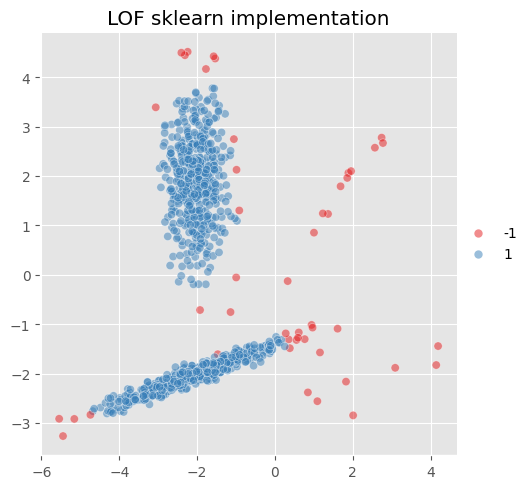

In [22]:
sns.relplot(x=X[:,0],y=X[:,1],hue=ypred2,palette="Set1",alpha=0.5)
plt.title('LOF sklearn implementation')
plt.show()